# HELIOS Demo
This notebook demonstrates the basic usage of the HELIOS simulation package.

In [1]:
import sys
sys.path.insert(0, '../src')
import helios
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

## 1. Define the Scene
We start by creating a scene with a star and a planet. The distance to the system is defined at the Scene level.

In [ ]:
scene = helios.Scene(distance=10*u.pc)

# Star at the center
star = helios.Star(temperature=5700*u.K, magnitude=5, mass=1*u.M_sun, position=(0*u.AU, 0*u.AU))

# Planet at 1 AU
planet = helios.Planet(mass=1*u.M_jup, position=(1*u.AU, 0*u.AU))

scene.add(star)
scene.add(planet)
# Add zodiacal and exozodiacal light components
zodi = helios.Zodiacal(brightness=0.5)
exozodi = helios.ExoZodiacal(brightness=0.3)
scene.add(zodi)
scene.add(exozodi)
print(f"Scene created with {len(scene.objects)} objects.")

Scene created with 4 objects.


### Visualize the Scene
We can visualize the scene geometry.

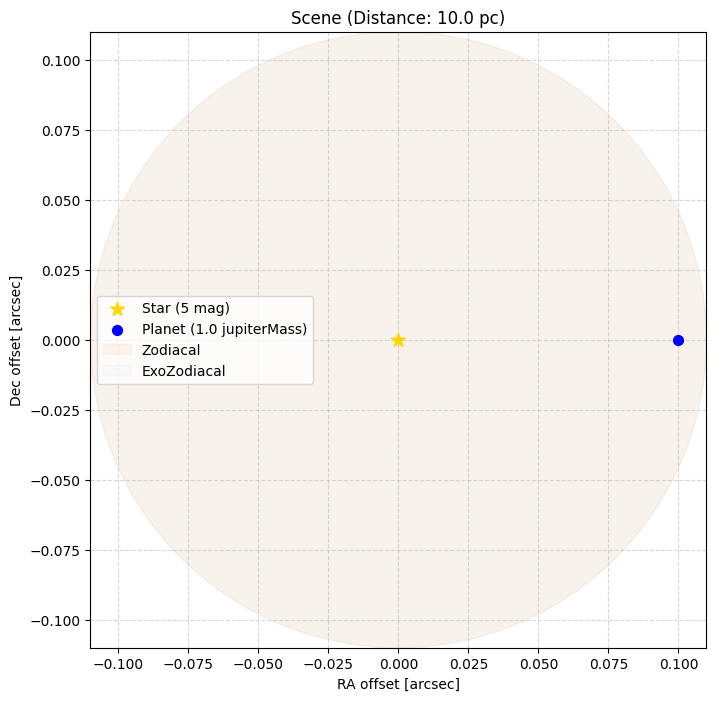

In [3]:
scene.plot()
plt.show()

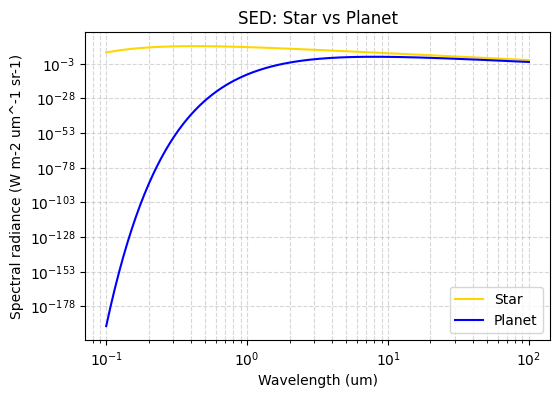

In [4]:
# Plot SEDs for star and planet using the new helper
ax = star.plot_sed(color='gold', label='Star', )
ax = planet.plot_sed(ax=ax, color='blue', label='Planet')
ax.set_title('SED: Star vs Planet')
plt.show()

## 2. Define Optics and Detectors
Next, we define the telescope and camera.

In [ ]:
collectors = helios.Collectors(latitude=0*u.deg, longitude=0*u.deg, altitude=2400*u.m)
pupil = helios.Pupil(8*u.m)
collectors.add(size=8*u.m, shape=pupil, position=(0,0))

camera = helios.Camera(pixels=(256, 256))

context = helios.Context()
context.add_layer(scene)
context.add_layer(collectors)
context.add_layer(camera)

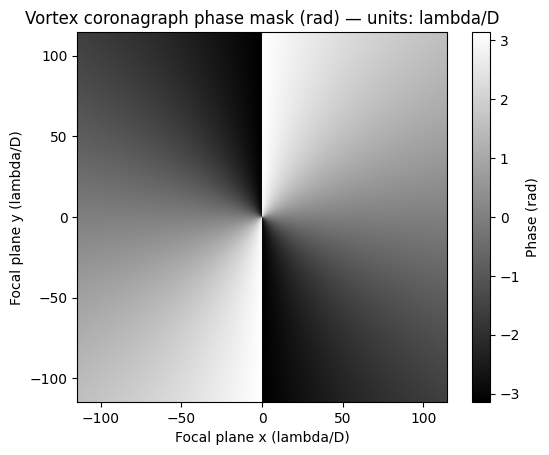

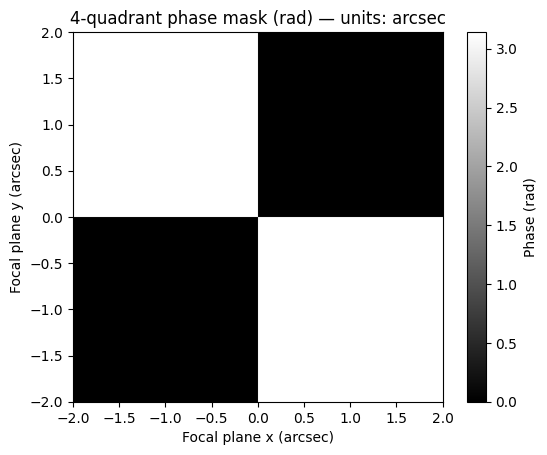

In [ ]:
# Visualiser les masques de phase des coronographes (exemples en unités physiques)
from astropy import units as u
import matplotlib.pyplot as plt

# Paramètres d'échelle physique
lam = 550e-9 * u.m
D = 6.5 * u.m
fov = 4 * u.arcsec

# Exemple 1: masque vortex (charge 2) — affichage en lambda/D
coro_v = helios.Coronagraph(phase_mask='vortex')
ax = coro_v.plot_mask(npix=512, kind='vortex', charge=2, lam=lam, diameter=D, fov=fov, display='lambda/d')
ax.set_title('Vortex coronagraph phase mask (rad) — units: lambda/D')
plt.show()

# Exemple 2: 4-quadrants (pi phase shifts) — affichage en arcsec
coro_4q = helios.Coronagraph(phase_mask='4quadrants')
ax2 = coro_4q.plot_mask(npix=512, kind='4quadrants', lam=lam, diameter=D, fov=fov, display='arcsec')
ax2.set_title('4-quadrant phase mask (rad) — units: arcsec')
plt.show()

## Pupil Construction Demo
This cell shows how to construct a pupil by hand and how to obtain a preset (JWST).
You can retrieve the final pupil as a NumPy array with `get_array(...)` and display it with `plot(...)`.

Manual pupil array shape: (256, 256) min/max: 0.0 1.0


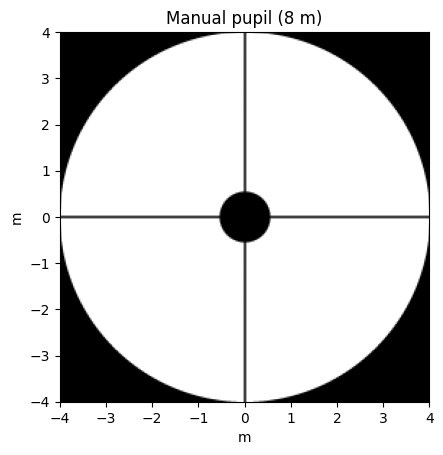

JWST pupil array shape: (512, 512)


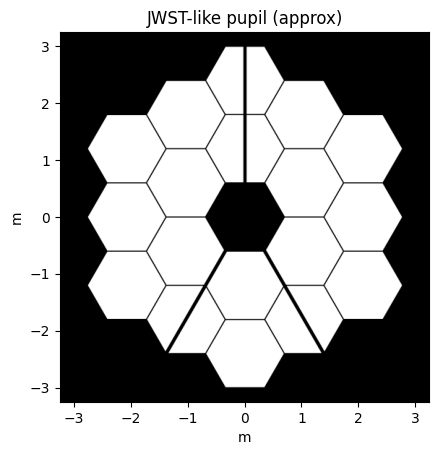

In [ ]:
# Manual pupil: simple 8-m class pupil with 4 spiders and central obscuration
p_manual = helios.Pupil(8*u.m)
p_manual.add_disk(radius=4.0 * u.m)
p_manual.add_central_obscuration(diameter=1.1 * u.m)
p_manual.add_spiders(arms=4, width=0.05 * u.m)

arr_manual = p_manual.get_array(npix=512)
print(f"Manual pupil shape: {arr_manual.shape}")

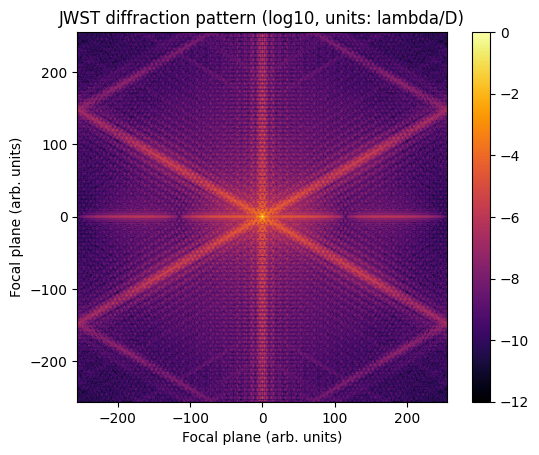

In [ ]:
# Diffraction pattern demo for JWST preset
p_jwst = helios.Pupil.like('JWST')
# show diffraction pattern in log scale (units: lambda/D)
ax = p_jwst.plot_diffraction_pattern(npix=512, log=True, cmap='inferno', wavelength=550e-9)
ax.set_title('JWST diffraction pattern (log10, units: lambda/D)')
plt.show()

### Image formation demo
Render the `Scene` to an image and propagate it through the pupil to obtain the instrument image.

Scene render shape, min/max: (256, 256) 0.04927866464995703 1.0


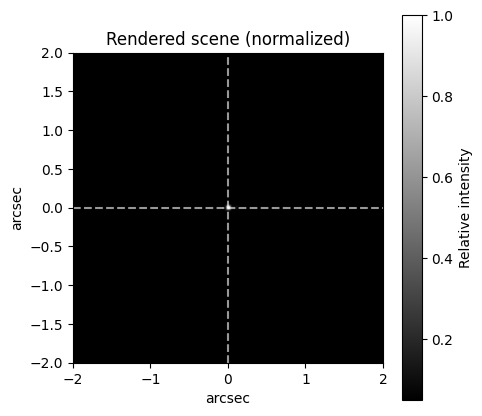

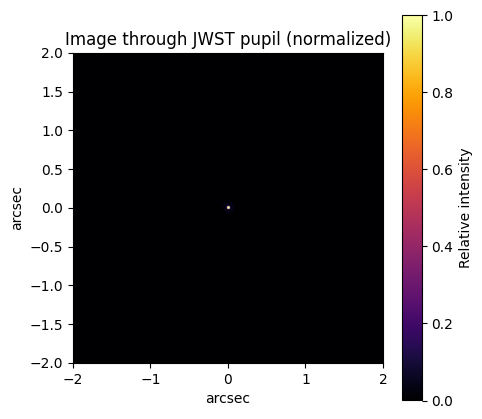

In [ ]:
# Render the scene (in arcsec) to a small image and form the instrument image through the JWST pupil
scene_img, x, y = scene.render(npix=256, fov=4*u.arcsec, return_coords=True)
print('Scene render shape, min/max:', scene_img.shape, scene_img.min(), scene_img.max())
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
extent = [x[0].value, x[-1].value, y[0].value, y[-1].value]
im0 = ax.imshow(scene_img, origin='lower', cmap='gray', extent=extent, aspect='equal')
ax.set_title('Rendered scene (normalized)')
ax.set_xlabel('arcsec')
ax.set_ylabel('arcsec')
ax.axvline(0.0, color='white', ls='--', alpha=0.6)
ax.axhline(0.0, color='white', ls='--', alpha=0.6)
plt.colorbar(im0, ax=ax, label='Relative intensity')
plt.show()
# propagate through pupil
p_jwst = helios.Pupil.like('JWST')
img = p_jwst.image_through_pupil(scene_img, soft=True)
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
im1 = ax.imshow(img, origin='lower', cmap='inferno', extent=extent, aspect='equal')
ax.set_title('Image through JWST pupil (normalized)')
ax.set_xlabel('arcsec')
ax.set_ylabel('arcsec')
plt.colorbar(im1, ax=ax, label='Relative intensity')
plt.show()

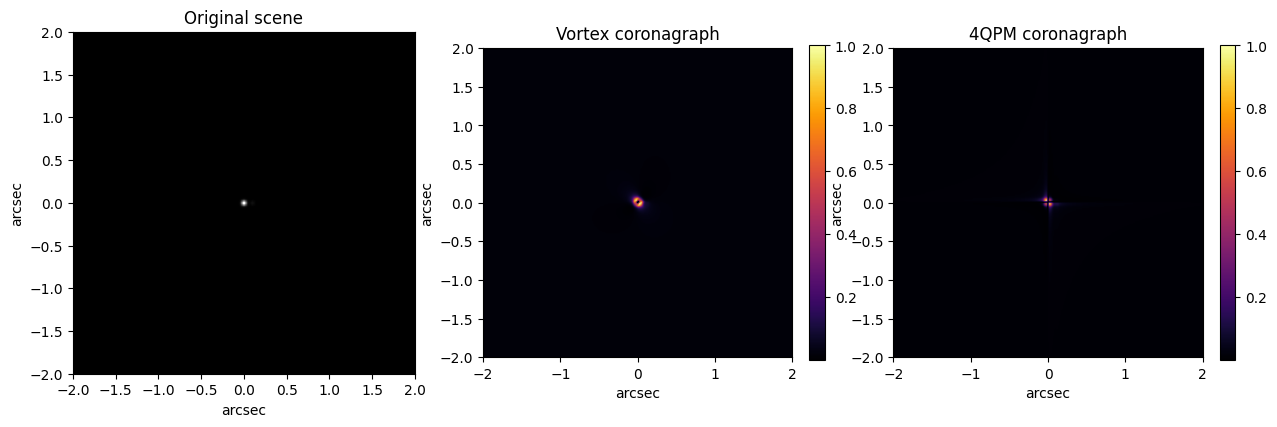

In [ ]:
# Coronagraph demo: compare vortex and 4-quadrant masks (scaled in lambda/D)
from astropy import units as u
# create coronagraph instances
cor_vortex = helios.Coronagraph(phase_mask='vortex')
cor_4q = helios.Coronagraph(phase_mask='4quadrants')
# wavelength and telescope diameter to set mask scale (lambda/D)
lam = 550e-9 * u.m
D = 6.5 * u.m
fov = 4 * u.arcsec
# compute coronagraphic images using physical scaling (lam, diameter, fov)
img_vortex = cor_vortex.image_from_scene(scene_img, soft=True, oversample=4, normalize=True, lam=lam, diameter=D, fov=fov)
img_4q = cor_4q.image_from_scene(scene_img, soft=True, oversample=4, normalize=True, lam=lam, diameter=D, fov=fov)
# plot original and coronagraphic images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
extent = [x[0].value, x[-1].value, y[0].value, y[-1].value]
axes[0].imshow(scene_img, origin='lower', cmap='gray', extent=extent, aspect='equal')
axes[0].set_title('Original scene')
axes[1].imshow(img_vortex, origin='lower', cmap='inferno', extent=extent, aspect='equal')
axes[1].set_title('Vortex coronagraph')
axes[2].imshow(img_4q, origin='lower', cmap='inferno', extent=extent, aspect='equal')
axes[2].set_title('4QPM coronagraph')
for ax in axes:
    ax.set_xlabel('arcsec')
    ax.set_ylabel('arcsec')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046)
plt.colorbar(axes[2].images[0], ax=axes[2], fraction=0.046)
plt.show()

**Atmosphere vs Ideal PSF (note on normalization)**

The comparisons below normalize all PSFs to the peak of the *ideal* (no-atmosphere) PSF.
This makes changes in the central peak (Strehl) visible: Strehl = peak_after / peak_ideal.
We also show a difference map (ideal - after_atm) to highlight where energy is redistributed or lost.

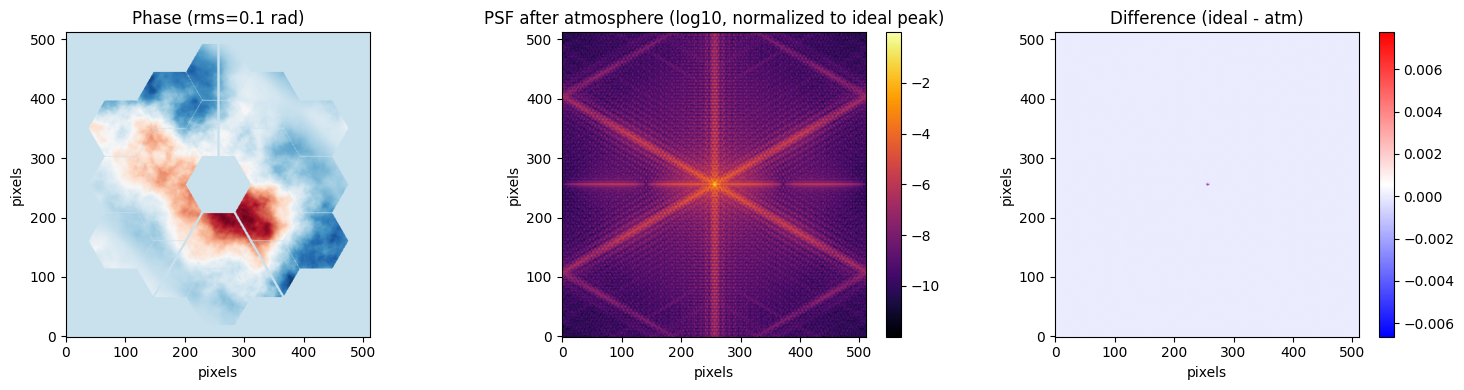

RMS=0.10 rad: Strehl (atm)=0.992, Strehl (AO)=0.979


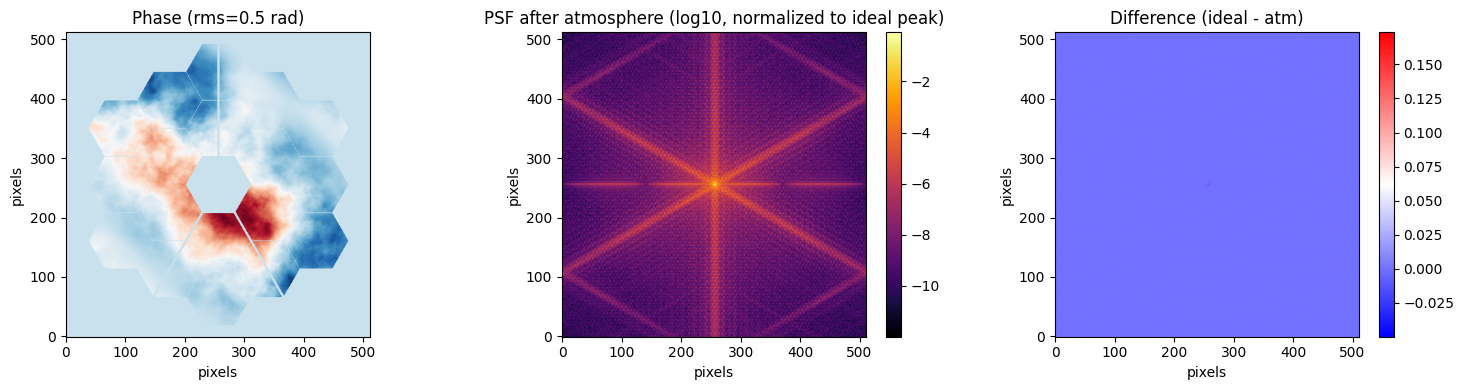

RMS=0.50 rad: Strehl (atm)=0.826, Strehl (AO)=0.826


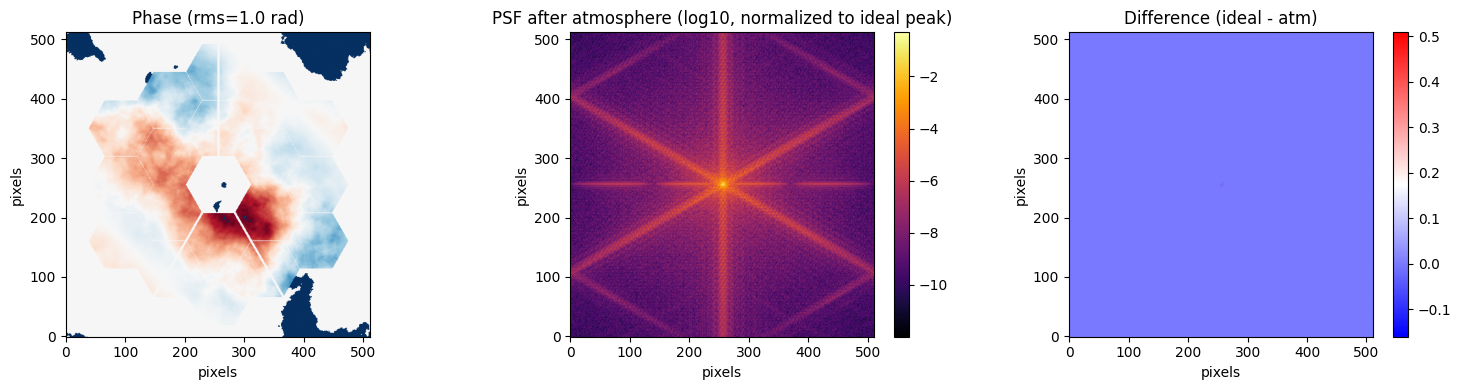

RMS=1.00 rad: Strehl (atm)=0.491, Strehl (AO)=0.496

Summary (rms, strehl_atm, strehl_ao):
(0.1, np.float64(0.9922723761953866), np.float64(0.9790149890542769))
(0.5, np.float64(0.8264968246295024), np.float64(0.8264524853294873))
(1.0, np.float64(0.491244673041929), np.float64(0.4957333791231679))


In [ ]:
# Atmosphere + Adaptive Optics: compare multiple RMS strengths
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

# wavelength and array size
wavelength = 550e-9 * u.m
N = 512

# build pupil amplitude (JWST-like)
pupil = helios.Pupil.like('JWST')
p_amp = pupil.get_array(npix=N, soft=True)

# compute ideal (no-atmosphere) PSF
wf_ideal = helios.Wavefront(wavelength=wavelength, size=N)
wf_ideal.field = p_amp.astype(np.complex128)
field_ideal = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(wf_ideal.field)))
psf_ideal = np.abs(field_ideal) ** 2
peak_ideal = psf_ideal.max()

# list of (atm_rms, ao_rms, subplot_title) tuples
test_cases = [
    (100e-9, 0, "Atm 100nm, no AO"),
    (100e-9, 80e-9, "Atm 100nm, AO 80nm"),
    (200e-9, 0, "Atm 200nm, no AO"),
    (200e-9, 150e-9, "Atm 200nm, AO 150nm"),
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (atm_rms, ao_rms, title) in enumerate(test_cases):
    # create wavefront
    wf = helios.Wavefront(wavelength=wavelength, size=N)
    wf.field = p_amp.astype(np.complex128)
    
    # apply atmosphere
    atm = helios.Atmosphere(rms=atm_rms * u.m)
    wf_atm = atm.process(wf)
    
    # optionally apply AO
    if ao_rms > 0:
        ao = helios.AdaptiveOptics(rms=ao_rms * u.m)
        wf_final = ao.process(wf_atm)
    else:
        wf_final = wf_atm
    
    # compute PSF
    field_final = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(wf_final.field)))
    psf_final = np.abs(field_final) ** 2
    
    # normalize all PSFs to ideal peak
    psf_norm_ideal = psf_ideal / peak_ideal
    psf_norm_final = psf_final / peak_ideal
    
    # compute Strehl (peak ratio)
    strehl = psf_final.max() / peak_ideal
    
    # difference map
    diff = psf_norm_ideal - psf_norm_final
    
    # plot final PSF
    axes[i].imshow(np.log10(psf_norm_final + 1e-10), origin='lower', cmap='inferno')
    axes[i].set_title(f"{title}\nStrehl={strehl:.3f}")
    axes[i].axis('off')
    
    # plot difference in the second row
    axes[i+4].imshow(diff, origin='lower', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axes[i+4].set_title("Difference (ideal - final)")
    axes[i+4].axis('off')

plt.tight_layout()
plt.show()

## 3. Run Simulation
Finally, we run the simulation.

In [12]:
result = context.observe()
print("Simulation complete. Result shape:", result.shape)

Simulation complete. Result shape: (256, 256)
